## Overview

In this notebook, we explore the movie rating data.

In [55]:
! rm -f ratings.dat
! wget https://raw.githubusercontent.com/snowch/movie-recommender-demo/master/web_app/data/ratings.dat

--2017-04-21 13:45:20--  https://raw.githubusercontent.com/snowch/movie-recommender-demo/master/web_app/data/ratings.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389458 (9.0M) [text/plain]
Saving to: ‘ratings.dat’

100%[======================================>] 9,389,458   --.-K/s   in 0.1s    

2017-04-21 13:45:20 (64.3 MB/s) - ‘ratings.dat’ saved [9389458/9389458]



## Load rating data

Let's check the structure of the data ...

In [56]:
! head -3 ratings.dat
! echo
! tail -3 ratings.dat

1::639::4::N/A
1::2239::5::N/A
1::533::2::N/A

5999::1767::3::N/A
5999::2318::5::N/A
5999::1455::5::N/A


Ok, so we should have:

`UserID::MovieID::Rating::Timestamp`

Now load the data into a RDD:

In [57]:
from pyspark.mllib.recommendation import Rating

ratingsRDD = sc.textFile('ratings.dat') \
               .map(lambda l: l.split("::")) \
               .map(lambda p: Rating(
                                  user = int(p[0]), 
                                  product = int(p[1]),
                                  rating = float(p[2]), 
                                  )).cache()

It's useful to check some highlevel statistics on the data.  For example, we can see that ratings are between 1.0 and 5.0

In [58]:
ratingsRDD.toDF().describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|           product|            rating|
+-------+------------------+------------------+------------------+
|  count|            510480|            510480|            510480|
|   mean| 3008.124294781382|1304.8709704591756| 3.463393276915844|
| stddev|1733.1095017453922| 752.5256128687262|1.2772692083455215|
|    min|                 1|                 1|               1.0|
|    max|              5999|              2608|               5.0|
+-------+------------------+------------------+------------------+



## Explore the data

First we we zoom in to visualize the ratings for a subset of users (user id < 10 and movie id < 20). We should see a sparse matrix.  
After that, we can zoom back out to look at the ratings for all of the users across all of the movies.

### Visualise the ratings matrix using a subset of the data

Let's take a subset of the data

In [59]:
ratings = ratingsRDD.filter(lambda x: x.user < 20 and x.product < 20).toDF()

Separate the x (user) values and also the y (movie) values for matplotlib.<br>
Also normalise the rating value so that it is between 0 and 1.  This is required for coloring the markers.

In [60]:
from pyspark.sql.functions import min, max

user = ratings.map(lambda x: int(x.user)).cache()
movie = ratings.map(lambda x: int(x.product)).cache()

min_r = ratings.select(min('rating')).take(1)[0]['min(rating)']
max_r = ratings.select(max('rating')).take(1)[0]['max(rating)']

def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratings.map(lambda x: normalise(x.rating)).cache()

We can now plot the sparse matrix of ratings for this subset of users and movies.

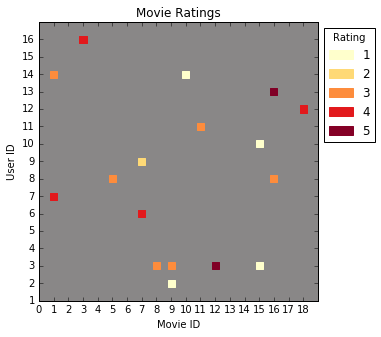

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

min_user = ratings.select(min('user')).take(1)[0]['min(user)']
max_user = ratings.select(max('user')).take(1)[0]['max(user)']
min_movie = ratings.select(min('product')).take(1)[0]['min(product)']
max_movie = ratings.select(max('product')).take(1)[0]['max(product)']

width = 5
height = 5
plt.figure(figsize=(width, height))
plt.ylim([min_user-1,max_user+1])
plt.xlim([min_movie-1,max_movie+1])
plt.yticks(np.arange(min_user-1, max_user+1, 1))
plt.xticks(np.arange(min_movie-1, max_movie+1, 1))
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.title('Movie Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    movie.collect(), 
    user.collect(), 
    s=50,
    marker="s",
    color=colors,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

In the plot, you can see the ratings color code.  For example User 1 has rated movie 1 with the highest rating of 5.<br>
Let's dump the dataset to double check ...

In [62]:
ratings.collect()

[Row(user=2, product=9, rating=1.0),
 Row(user=3, product=15, rating=1.0),
 Row(user=3, product=9, rating=3.0),
 Row(user=3, product=12, rating=5.0),
 Row(user=3, product=8, rating=3.0),
 Row(user=6, product=7, rating=4.0),
 Row(user=7, product=1, rating=4.0),
 Row(user=8, product=16, rating=3.0),
 Row(user=8, product=5, rating=3.0),
 Row(user=9, product=7, rating=2.0),
 Row(user=10, product=15, rating=1.0),
 Row(user=11, product=11, rating=3.0),
 Row(user=12, product=18, rating=4.0),
 Row(user=13, product=16, rating=5.0),
 Row(user=14, product=10, rating=1.0),
 Row(user=14, product=1, rating=3.0),
 Row(user=16, product=3, rating=4.0)]

The plot is as expected, so we can repeat this with the full data set.

### Visualise the ratings matrix using the full data set

This time we don't need to filter the RDD

In [63]:
ratings = ratingsRDD.toDF()

Same functions as before ...

In [64]:
from pyspark.sql.functions import min, max

user = ratings.map(lambda x: int(x.user)).cache()
movie = ratings.map(lambda x: int(x.product)).cache()

min_r = ratings.select(min('rating')).take(1)[0]['min(rating)']
max_r = ratings.select(max('rating')).take(1)[0]['max(rating)']

def normalise(x):
    rating = (x - min_r) / (max_r - min_r)
    return float(rating)

ratingN = ratings.map(lambda x: normalise(x.rating)).cache()

Slightly modified chart, for example to print out smaller markers

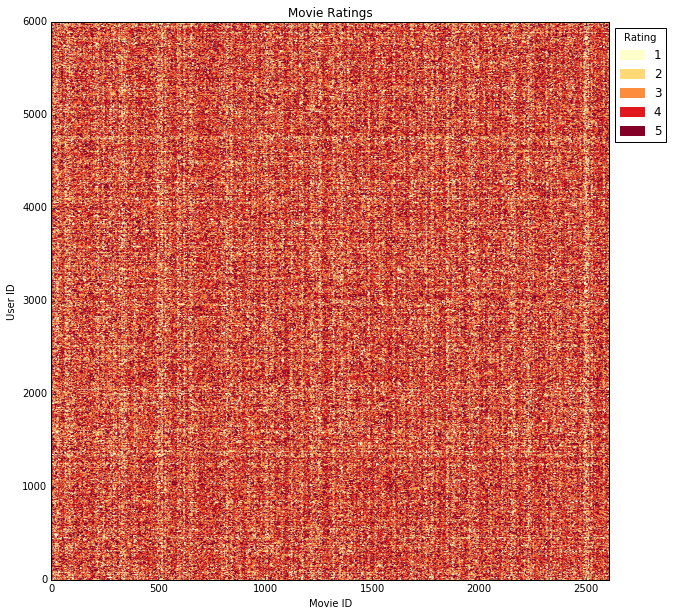

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

max_user = ratings.select(max('user')).take(1)[0]['max(user)']
max_movie = ratings.select(max('product')).take(1)[0]['max(product)']

width = 10
height = 10
plt.figure(figsize=(width, height))
plt.ylim([0,max_user])
plt.xlim([0,max_movie])
plt.ylabel('User ID')
plt.xlabel('Movie ID')
plt.title('Movie Ratings')

ax = plt.gca()
ax.patch.set_facecolor('#898787') # dark grey background

colors = plt.cm.YlOrRd(ratingN.collect())

plt.scatter(
    movie.collect(), 
    user.collect(), 
    s=1,
    edgecolor=colors)

plt.legend(
    title='Rating',
    loc="upper left", 
    bbox_to_anchor=(1,1),
    handles=[
        mpatches.Patch(color=plt.cm.YlOrRd(0),    label='1'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.25), label='2'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.5),  label='3'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.75), label='4'),
        mpatches.Patch(color=plt.cm.YlOrRd(0.99), label='5')    
    ])

plt.show()

We can see some clear patterns.  The vertical lines could indicate that the movie is rated similarly by all users.<br>
The horizontal lines could also indicate that a person ranks all movies fairly similarly - if a pale line, they tend to rate negatively and dark red positively.<br>
There are some interesting grey patterns too, where users have not rated movies. Notice the grey arc at the top right of the plot.<br>

## Understanding the ALS model

### Definitions

ALS generates user and product features from the rating data (the matrix on the left). 
See [here](https://skillsmatter.com/skillscasts/9819-building-an-open-source-movie-recommender-using-apache-spark-and-ibm-cloud-data-services) for more information on ALS.

<div style="text-align:center" markdown="1">
<img src="https://raw.githubusercontent.com/snowch/movie-recommender-demo/master/docs/latent_factors.png" width="60%" style="float: center;" />
</div>

#### Latent factors

The **Product Features** and **User Features** are referred to as **latent** factors because we don't know (or care) what they actually represent - their meaning is hidden (latent) from us. The number of latent features is also called the **rank**.  In the example above, we are assuming that there are five features, so the rank is 5.

It may help you intuitively if you think of the latent features as representing movie attributes such as genre, actors or release date.

#### Iterations

The ALS algorithm when generating the **Product Features** and **User Features** works approximately like this:

 1. Generate random values for the Product Features
 2. Fix Product Features and solve User Features, calculate least squares error
 3. Fix User Features and solve Product Features, calculate least squares error
 4. Repeat (Alternate) steps 2 and 3 until a number of iterations has been performed
 
After each iteration the least squares error will be lower than the previous iteration.  The optimum number of iterations can be determined by experimentation.

#### Lambda

If the ALS algorithm just solved using least squares there is a potential that the generated User and Product features will be overfitted to the data.  The Lambda parameter prevents overfitting.  The optimum value for the Lambda parameter can be determined by experimentation.

### Building the model (user and product features)

In [66]:
from pyspark.mllib.recommendation import ALS

# rank is the number of latent feature
rank = 5
numIterations = 20
lambdaParam = 0.1
model = ALS.train(ratings, rank, numIterations, lambdaParam)

Let's take a peek at the user features for user IDs 1 and 2

In [67]:
model.userFeatures().sortByKey().take(2)

[(1,
  array('d', [0.3996094763278961, -0.16890069842338562, 0.5432009100914001, -0.2912166714668274, -1.793383240699768])),
 (2,
  array('d', [0.37502726912498474, -0.4962605834007263, 0.33655214309692383, -0.3355659246444702, -0.5028182864189148]))]

Let's take a peek at the product features for movie IDs 1 and 2

In [68]:
model.productFeatures().sortByKey().take(2)

[(1,
  array('d', [0.1686459481716156, -0.28182002902030945, 0.5167853236198425, -0.31165266036987305, -1.9129575490951538])),
 (2,
  array('d', [0.5045013427734375, -0.4603715240955353, 0.3380671739578247, -0.3744378685951233, -1.6920006275177002]))]

We can now use linear algebra to predict the rating 'manually' directly from the user and product features for user ID=1 and movie ID=1:

In [69]:
import numpy as np
np.dot( 
    model.userFeatures().sortByKey().take(1)[0][1], 
    model.productFeatures().sortByKey().take(1)[0][1] 
)

3.9171348360011358

Spark provides an API so we don't have to perform the manual calculations.  
Let's use the spark API to predict a rating:

In [70]:
model.predict(user=1, product=1)

3.9171348360011358

Spark also has API's to perform bulk calculations such as predicting the top X products for all users.  Let's look at the data for two users (`.take(2)`):

In [71]:
top_ten_for_all_users = model.recommendProductsForUsers(5).toDF().take(2)

Pretty print the recommendations

In [72]:
for user in top_ten_for_all_users:
    print('')
    for prediction in user['_2']:
        print(prediction)


Row(user=4904, product=1330, rating=4.304529767758929)
Row(user=4904, product=2006, rating=4.2932396426111215)
Row(user=4904, product=571, rating=4.292360125690777)
Row(user=4904, product=1008, rating=4.291990884545714)
Row(user=4904, product=180, rating=4.280610972146317)

Row(user=1084, product=2551, rating=4.369831783788951)
Row(user=1084, product=1190, rating=4.360708377286075)
Row(user=1084, product=2476, rating=4.3606607359902085)
Row(user=1084, product=1937, rating=4.352066999078676)
Row(user=1084, product=1378, rating=4.3514396334428085)


In the production web application, we predict the top 10 products for all users every hour and we populate the recommendations in a Cloudant database where they can be easily accessed by the web application code.